# AI Face Mask Detector

+ Exploring the dataset 
+ Creating Training and Validation Sets 
+ Creating class for building Convolutional Neural Network


### Exploring the dataset 

The dataset available in following Kaggle source seems good. It is already classified in train, test and validation set. 

https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

There are only two type of classification in this dataset 

1. with mask 
2. no mask 



#### Setting the folder 

In [2]:

# importing modules 
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

print("Hello World!")

#Preparing the data 
TEST_DIR = "Dataset/Test"
TRAIN_DIR = "Dataset/Train"
VAL_DIR = "Dataset/Validation"

#try:

print("try-exception block")

transform_train= T.Compose([T.Resize((32, 32)),T.CenterCrop(32),T.ToTensor()])
train_ds = ImageFolder(root=TRAIN_DIR, transform=transform_train)

transform_val = T.Compose([T.Resize((32,32)),T.ToTensor() ])
val_ds = ImageFolder(root=VAL_DIR, transform=transform_val)

transform_test = T.Compose([T.Resize((32,32)),T.ToTensor() ])
test_ds = ImageFolder(root=TEST_DIR, transform=transform_test)

batch_size= 15
learning_rate = 0.001
num_epochs = 5
num_classes = 2
num_workers = 3
train_loader = DataLoader(train_ds, batch_size=400, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=3, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds,
                                       batch_size=100, 
                                       num_workers=num_workers,
                                       shuffle=True)

loaders_scratch = {
'train': train_loader,
'valid': val_loader,
'test': test_loader
}

#except:
#    print("exception occurred! ")
#    print("Unexpected error:", sys.exc_info())
print("end of cell")

Hello World!
try-exception block
end of cell


#### showing the batches 

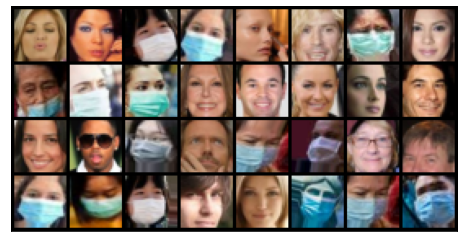

In [3]:
def show_batch(train_dl):
    for images, labels in train_dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1,2,0))
        break
        
show_batch(train_loader)

Now creating a class using nn.module

In [4]:
import torch.nn as nn
import torch.nn.functional as F

total_mask_classes = 2

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN0
        # convolutional layer (sees  32x32x3 image tensor?)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        #self.norm2d1 = nn.BatchNorm2d(32)
        # convolutional layer 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer 
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # pool
        # max pooling layer 
        self.pool = nn.MaxPool2d(2, 2)

        size_linear_layer = 500
        
        # linear layer (128 * 28 * 28 -> 500)
        #self.fc1 = nn.Linear(128 * 28 * 28, size_linear_layer)
        
    
        self.fc1 = nn.Linear(64 * 4 * 4, size_linear_layer)
        self.dropout=nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(size_linear_layer, total_mask_classes)
        #self.fc2=nn.Dropout(p=0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print("x.shape",x.shape)
        
        # flatten image input
        # x = x.view(-1, 128 * 28 * 28)
        #print("x.size0: ", x.size(0))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Before training the model, you have to first create an instance of the Convolution class you defined in previous part, then define the loss function and optimizer:

In [5]:
# instantiate the CNN
model_scratch = Net()
print(model_scratch)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)


In [6]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("use_cuda: " , use_cuda)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch = model_scratch.cuda()

use_cuda:  False


#### specify loss function and optimizer 

In [7]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = torch.optim.Adam(model_scratch.parameters(), lr=learning_rate)

#### train and validate model 

In [8]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returning trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    print("epochs:" ,n_epochs)
    print("use_cuda: ", use_cuda)
    print("save_path: ", save_path)
    print("started training ...")
    for epoch in range(1, n_epochs+1):
        #print("Training for epoch .....: " , epoch)
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # trains the model
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## this step finds loss and update model parameters
            
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
        # validate the model         
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

epochs: 5
use_cuda:  False
save_path:  model_scratch.pt
started training ...
Epoch: 1 	Training Loss: 0.686186 	Validation Loss: 0.656095
Validation loss decreased (inf --> 0.656095).  Saving model ...
Epoch: 2 	Training Loss: 0.624609 	Validation Loss: 0.540193
Validation loss decreased (0.656095 --> 0.540193).  Saving model ...
Epoch: 3 	Training Loss: 0.480133 	Validation Loss: 0.319653
Validation loss decreased (0.540193 --> 0.319653).  Saving model ...
Epoch: 4 	Training Loss: 0.275215 	Validation Loss: 0.134506
Validation loss decreased (0.319653 --> 0.134506).  Saving model ...
Epoch: 5 	Training Loss: 0.134116 	Validation Loss: 0.077341
Validation loss decreased (0.134506 --> 0.077341).  Saving model ...


<All keys matched successfully>

Now keep track of the accuracy on the test set. The predictions of the model can be determined by using torch.max()

#### test the model



In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
       
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.085848


Test Accuracy: 96% (867/896)
